# A finite difference model as a Python function
*Prof. dr.ir.T.N.Olsthoorn*

*Heemstede, Sept. 2016*

## Generalize the finite difference model into a callable function

The 3D finite difference computation in the previous chapter can be generalized by putting the generic parts in a callable Python function and turning the the user or case specific data into the arguments by which the function is called like so:

Phi = fdm3( x, y, z, kx, ky, kz, FQ, IH, IBOUND )

Doing so and adding some input error checking for convenience leads to the following code, that is save to disk for future use:

In [5]:
%%writefile fdm_a.py
# write the function in this cell to disk as file fdm.py

import numpy as np
#import pdb  # in case we need to debug this function

def fdm3(x, y, z, kx, ky, kz, FQ, HI, IBOUND):
    '''Returns computed heads of steady state 3D finite difference grid.
    
    Steady state 3D Finite Difference Model that computes the heads a 3D ndarray.
    
    Parameters
    ----------
    `x` : ndarray, shape: Nx+1, [L]
        `x` coordinates of grid lines perpendicular to rows, len is Nx+1
    `y` : ndarray, shape: Ny+1, [L]
        `y` coordinates of grid lines along perpendicular to columns, len is Ny+1
    `z` : ndarray, shape: Nz+1, [L]
        `z` coordinates of layers tops and bottoms, len = Nz+1
    `kx`, `ky`, `kz` : ndarray, shape: (Ny, Nx, Nz) [L/T]
        hydraulic conductivities along the three axes, 3D arrays.
    `FQ` : ndarray, shape: (Ny, Nx, Nz), [L3/T]
        prescrived cell flows (injection positive, zero of no inflow/outflow)
    `IH` : ndarray, shape: (Ny, Nx, Nz), [L]
        initial heads. `IH` has the prescribed heads for the cells with prescribed head.
    `IBOUND` : ndarray of int, shape: (Ny, Nx, Nz), dim: [-]
        boundary array like in MODFLOW with values denoting
        * IBOUND>0  the head in the corresponding cells will be computed
        * IBOUND=0  cells are inactive, will be given value NaN
        * IBOUND<0  coresponding cells have prescribed head
    
    Returns
    -------    
    `Phi` : ndarray, shape: (Ny, Nx, Nz), [L]
        the 3D array with the final heads with `NaN` at inactive cells.
    
    TO 160905
    '''

    import numpy as np
    import scipy.sparse as sp
    from scipy.sparse.linalg import spsolve # to use its short name
#    pdb.set_trace()
    x = np.sort(np.array(x))       # enforce ascending
    y = np.sort(np.array(y))[::-1] # enforce descending
    z = np.sort(np.array(z))[::-1] # enforce descending
    
    # as well as the number of cells along the three axes
    SHP = Ny, Nx, Nz = len(y)-1, len(x)-1, len(z)-1

    Nod = np.prod(SHP)
    
    if Nod == 0:
        raise AssertationError("Nx, Ny and Nz must be >= 1")

    # assert correct shape of input arrays
    if kx.shape != SHP:
        raise AssertionError("shape of kx {0} differs from that of model {1}".format(kx.shape,SHP))
    if ky.shape != SHP:
        raise AssertionError("shape of ky {0} differs from that of model {1}".format(ky.shape,SHP))
    if kz.shape != SHP:
        raise AssertionError("shape of kz {0} differs from that of model {1}".format(kz.shape,SHP))
    
    # from this we have the width of columns, rows and layers
    dx = np.diff(x).reshape(1,Nx,1)
    dy = np.abs(np.diff(y).reshape(Ny,1,1)) # enforce positive
    dz = np.abs(np.diff(z)).reshape(1,1,Nz) # enforce positive
    
    active = (IBOUND>0).reshape(Nod,)  # boolean vector denoting the active cells
    inact  = (IBOUND==0).reshape(Nod,) # boolean vector denoting inacive cells
    fxhd   = (IBOUND<0).reshape(Nod,)  # boolean vector denoting fixed-head cells

    # half cell flow resistances
    Rx = 0.5 * dx / (dy * dz) / kx
    Ry = 0.5 * dy / (dz * dx) / ky
    Rz = 0.5 * dz / (dx * dy) / kz
    
    # set flow resistance in inactive cells to infinite
    Rx = Rx.reshape(Nod,); Rx[inact] = np.Inf; Rx=Rx.reshape(SHP)
    Ry = Ry.reshape(Nod,); Ry[inact] = np.Inf; Ry=Ry.reshape(SHP)
    Rz = Rz.reshape(Nod,); Rz[inact] = np.Inf; Rz=Rz.reshape(SHP)
    
    # conductances between adjacent cells
    Cx = 1 / (Rx[:,:-1,:] + Rx[:,1:,:])
    Cy = 1 / (Ry[:-1,:,:] + Ry[1:,:,:])
    Cz = 1 / (Rz[:,:,:-1] + Rz[:,:,1:])
    
    NOD = np.arange(Nod).reshape(SHP)
    
    IE = NOD[:,1:,:]  # east neighbor cell numbers
    IW = NOD[:,:-1,:] # west neighbor cell numbers
    IN = NOD[:-1,:,:] # north neighbor cell numbers
    IS = NOD[1:,:,:]  # south neighbor cell numbers
    IT = NOD[:,:,:-1] # top neighbor cell numbers
    IB = NOD[:,:,1:]  # bottom neighbor cell numbers
    
    R = lambda x : x.ravel()  # generate anonymous function R(x) as shorthand for x.ravel()

    # notice the call  csc_matrix( (data, (rowind, coind) ), (M,N))  tuple within tupple
    A = sp.csc_matrix(( -np.concatenate(( R(Cx), R(Cx), R(Cy), R(Cy), R(Cz), R(Cz)) ),\
                        (np.concatenate(( R(IE), R(IW), R(IN), R(IS), R(IB), R(IT)) ),\
                         np.concatenate(( R(IW), R(IE), R(IS), R(IN), R(IT), R(IB)) ),\
                      )),(Nod,Nod))
    
    # to use the vector of diagonal values in a call of sp.diags() we need to have it aa a 
    # standard nondimensional numpy vector.
    # To get this:
    # - first turn the matrix obtained by A.sum(axis=1) into a np.array by np.array( .. )
    # - then take the whole column to loose the array orientation (to get a dimensionless numpy vector)
    adiag = np.array(-A.sum(axis=1))[:,0]
    
    Adiag = sp.diags(adiag)  # diagonal matrix with a[i,i]
    
    RHS = FQ.reshape(Nod,1) - A[:,fxhd].dot(HI.reshape(Nod,1)[fxhd]) # Right-hand side vector
    
    Phi = HI.flatten() # allocate space to store heads
    
    Phi[active] = spsolve( (A+Adiag)[active][:,active] ,RHS[active] ) # solve heads at active locations
    
    Phi[inact] = np.NaN # put NaN at inactive locations
    
    return Phi.reshape(SHP) # reshape vector to 3D size of original model

Overwriting fdm_a.py


In [6]:
import numpy as np # we always need this
import fdm_a # import fdm_a module for use

from importlib import reload  # we need reload if we edited the file fdm_a.py
reload(fdm_a)  # if edited, must reload it

fdm3 = fdm_a.fdm3  # for convenience create a local name to just write fdm3

This function should be saved in a .py file e.g. "fdm3.py" so that it can be used as a module that can be imported by other users or programs or scripts.

## Apply the model

To apply the model we specify coofdinates, conductivities, prescribed flows and prescribed heads and the `IBOUND` array. Then we call the function with the proper arguments. After the function computed the heads, we'll show them by a contour plot.

###  Generate input to run the model with

The lines below are case specific and could be placed in a script that can be run to set up the model afterw which the model is called from the script with the proper arguments

In [7]:
# specify a rectangular grid
x = np.arange(-1000., 1000., 25.)
y = np.arange(-1000., 1000., 25.) # backward, i.e. first row grid line has highest y
z = np.arange(-100., 0., 20.)  # backward, i.e. from top to bottom

SHP = (len(y)-1, len(x)-1, len(z)-1)

k = 10.0 # m/d uniform conductivity
kx = k * np.ones(SHP) # [L/T] 3D kx array
ky = k * np.ones(SHP) # [L/T] 3D ky array with same values as kx 
kz = k * np.ones(SHP) # [L/T] 3D kz array with same values as kx

FQ = np.zeros(SHP)    # all flows zero. Note sz is the shape of the model grid
FQ[30, 25, 2] = -1200  # [m3/d] extraction in this cell

HI = np.zeros(SHP) # initial heads

IBOUND = np.ones(SHP)
IBOUND[-1,:,:] = -1  # last row of model heads are prescribed
IBOUND[40:45,20:70,:]=0 # these cells are inactive


### Call the function with the correct arguments

In [8]:
Phi = fdm3( x, y, z, kx, ky, kz, FQ, HI, IBOUND)

### Visualization of the results: plot heads as contours

Import the required plotting module and setup the plot and run ``%matplotlib notebook`` to allow plots beeing shown inside the notebook.

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt # combines namespace of numpy and pyplot

<IPython.core.display.Javascript object>


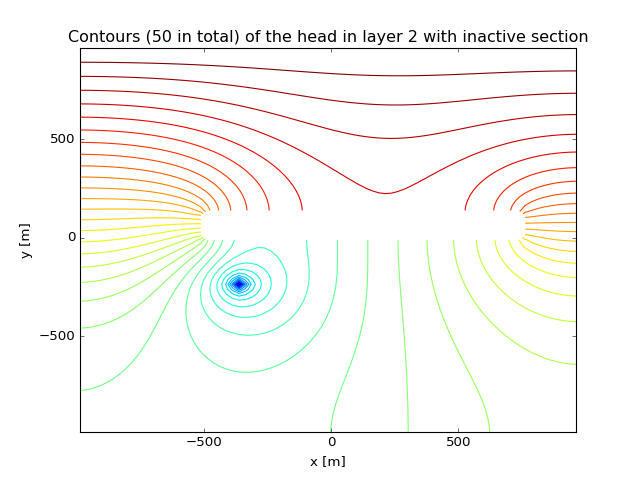

In [10]:
xm = 0.5 * (x[:-1] + x[1:]) # cell center coordinates
ym = 0.5 * (y[:-1] + y[1:]) # same
layer = 2 # contours for this layer
nc = 50   # number of contours in total

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Contours (%d in total) of the head in layer %d with inactive section" % (nc, layer))
plt.contour(xm, ym, Phi[:,:,layer], nc)

* The white area is the aquifer part that was defined as inactive (impervious).
* The red trough is the well location.
* The two flanks and the front sides are closed (no FQ and no fixed head).
* The head at the back side is prescribed and maintained at zero.

## Conclusion

We have developed from scratch a full 3D steady-state finite difference mode for which fixed heads, fixed flows and inactive subareas can be prescribed.

This model is general, it can be called as a function and allows solving a wide range of different 3D steady-state groundwater flow problems in a finite difference setting.

The function should be stored in a module (a .py file) and can then be imported from this module, like so

import mymodule

from mymodule import fdm3

## Examples

Here we set-up a few simple examples that we can readily verify analytically. The examples are 2D and can easily be computed with our 3D model.

In [11]:
# basic imports

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt # combines namespace of numpy and pyplot

import fdm_a
fdm3 = fdm_a.fdm3   # could also use from fdm_a import fdm3 (sets fdm3 as convenient local name).

### Example 1: flow between 2 fixed bounaries

Consider the flow in an aquifer with constant transmissivity `kD=1000` m2/d, with fixed head `h=0` at the left and the right boundaries at `x=-L/2` and `x=+L/2` respectively, subject to uniform precipitation `N`.

The analytical solution for this case is

$h = \frac N {2 kD} ( (\frac L 2) ^2-x^2) $


The model will consist of 1 layer, is `L=500` m wide, with cells of `dx=10` m and is subject to `N=0.01` m/d recharge.

In order to put the fixed heads at the outer cell centers exactly at $\pm -L/2$, we make the width of the outer cells very small, 0.001 m say.

In [12]:
# constants
N = 0.01 # m/d, precipitaion suplus
L = 500  # m,   width of the cross section
k = 10   # m/d, aquifer conductivity
D = 100  # m/d, aquifer thickness
L = 1000 # m,   width of the cross section
kD = k * D # m2/d, aquifer transmissivity

In [13]:
# model grid
x = np.hstack((-L/2-0.001, np.linspace(-L/2, L/2, 51), L/2+0.001))
y = np.array([-0.5, 0.5]) # make the model 1m wide
z = np.array([-D, 0])   # use thickenss of model

Ny, Nx, Nz = SHP = (len(y)-1, len(x)-1, len(z)-1)

# cell center coordinates
xm = .5 * (x[:-1] + x[1:])
ym = .5 * (y[:-1] + y[1:])
zm = .5 * (z[:-1] + z[1:])

# cell size
dx = np.diff(x);
dy = np.diff(y);
dz = np.diff(z);

In [14]:
# boundary array
IBOUND = np.ones(SHP)
IBOUND[:,[0, -1],:] = -1  # fix head of left and right boundary

# conductivitys array
K = k  * np.ones(SHP) 

# prescribed flow = precipitation surplus
FQ = np.ones(SHP)
FQ[:,:,0] = dx * N  

# Initial heads, all zero
HI = np.zeros(SHP)

In [15]:
# run the model to compute the heads
Phi = fdm3(x, y, z, K, K, K, FQ, HI, IBOUND)

Vizualisation of the computed heads:

<IPython.core.display.Javascript object>


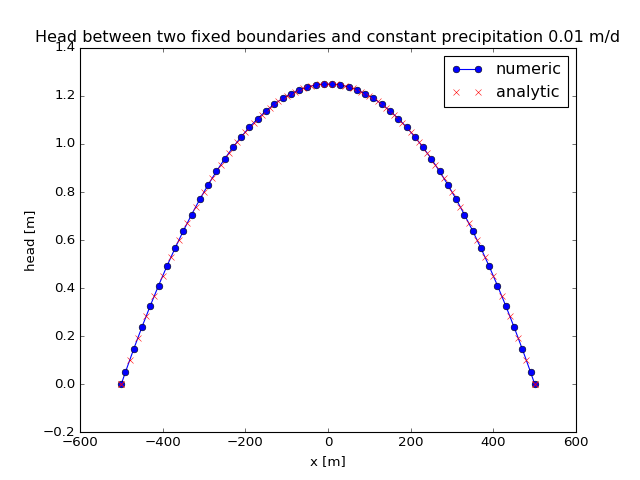

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt # combines namespace of numpy and pyplot

plt.figure()
plt.xlabel('x [m]')
plt.ylabel('head [m]')
plt.title('Head between two fixed boundaries and constant precipitation {0} m/d'.format(N))
plt.plot(xm, Phi.ravel(), 'bo-', label='numeric')

# now add the analytical solution
fi = N/(2*kD) * ((L/2)**2 - x**2)
plt.plot(x, fi, 'xr', label='analytic')
plt.legend()


This shows that the analytical and numerical solutions match. Notice, however, that we have made the outer two cells very narrow, so that the location of the `x[0]` and `xm[0]` and `x[-1]` and `xm[-1]` are almost indistinguishable, so that the position of the boundary are essentially the same for the numerical and the analytical model. (Just make the outer two cells as wide as the other cells to see the difference.

The 3D model was used here as a 1D model along the `x`-axis. It should be evident that our 3D numerical model is very flexible in modeling 1D, 2D as well as 3D situations.

## Example 2, semi-confined flow (mazure case)

Assume the case where we have a water body with constant head $h=h_w$ that at `x=0` is in direct contact with an semi aquifer that is charaterized with constant transmissivity `kD` convered by a semi-confining layer with constant resistance `c` above which we have a head that is maintained at a constant level $h=h_p$. This problem was solved by Marzure around 1930 when he studied groundwater flow from the IJssel Lake to a new adjacent polder with a 5 m lower maintained water level.

The analytical solution for the head in the regional aquifer, that is, below the confining layer is

$ \phi - h_p = (\phi_0 - h_p) \,\, \exp (-x / \lambda) $

with $\lambda = \sqrt {kD c}$

Let's work out this case to compare the analytical result with our model.

In [17]:
# import numpy as np, assumed numpy has been loaded above

k = 25 # m/d conductivity of regional aquifer
D = 50 # m   thickness of regional aquifer
d = 10 # m   thickness of confining layer
dtop = 0.001 # m dummy thickness of layer in which the head is maintained
c = 500.0 # d  vertical hydraulic resistance of confining layer
hw = -0.4   # m fixed IJssel lake elevation
hp = -5.0 # m fixed polder water elevation.

kD = k*D
lam = np.sqrt(kD * c)

In [18]:
x = np.hstack((-0.001, np.linspace(0, 5000, 100)))
y = np.array([-0.5, 0.5])
grs = 0 # m,  ground surface elevation
z = np.array([grs-D-d-dtop, grs-d-dtop, grs-dtop, grs])

In [19]:
Ny, Nx, Nz = SHP = len(y)-1, len(x)-1, len(z)-1
IBOUND = np.ones(SHP)
IBOUND[:,:,0] = -1 # fixed head maintained in top layer (above confining layer)
IBOUND[:,0,-1] = -1 # fiex head in aquifer at x=0

HI = np.zeros(SHP)
HI[:,0,-1] = hw # fixed level of IJssel Lake
HI[:,:,0] = hp # fixed polder level

FQ = np.zeros(SHP) # no fixed flows

kAquif = k;
kConf  = d/c;
kTop   = 100;  #immaterial

K = np.array([kTop, kConf, kAquif]).reshape(1,1,Nz) * np.ones(SHP)

In [20]:
Phi = fdm3(x, y, z, K, K, K, FQ, HI, IBOUND)

<IPython.core.display.Javascript object>


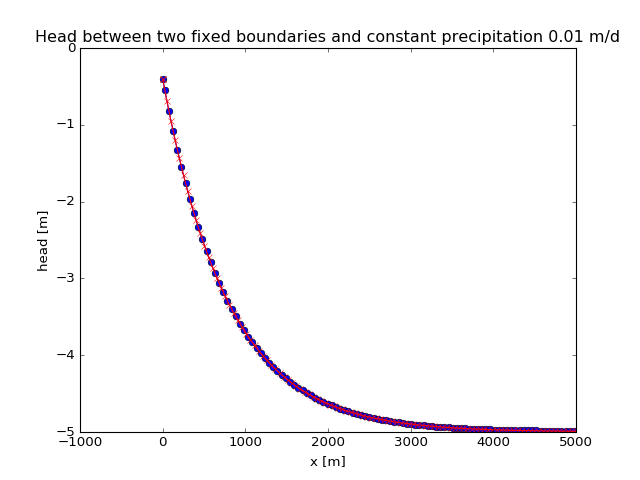

In [21]:
plt.figure()
plt.xlabel('x [m]')
plt.ylabel('head [m]')
plt.title('Head between two fixed boundaries and constant precipitation {0} m/d'.format(N))

xm = 0.5 * (x[:-1] + x[1:])
plt.plot(xm, Phi[0][:,-1], 'bo-')

# now add the analytical solution
fi = hp + (hw - hp) * np.exp(-x/lam)
plt.plot(x, fi, 'xr-')


As can be seen, the analytical and the numeical model match. Notice that here we made the first cell width very small, so that the fixed head in the first cell falls almost exactly at zero. Had we not done so, then the fixed head of the numerical model would have been at `xm[0] = 50` i.e. in the center of the first cell, while the fixed head in the analytical solution would still be at exactly `x = 0`, which would lead to a difference between the two solutions. Just try this by setting the width of the first model cell equal to 100 m instead of 0.001 m.

Another issue is that the numerical model is closed at the right-hand side, i.e. where `x = 5000 m`. In this example, this distance is so large that the effect of the left boundary is almost zero, so that the difference between the analytical solution and the numerical model is not visibile in the graph. Just try to make the right-hand side of the model less far to see the difference.

Of course one could easily fix the right-hand boundary as well as the left-hand one, to obtain a solution that is bounded by fixed heads on either side. It's easy to derive the analytical solution for that case as well and to verify it with the numerical model. This is left as an exercise to the student.

The analytical solution for the the same head at either side of the cross section is this

$\phi - h_p = (h_w - h_p ) \frac {\cosh (\frac x \lambda ) } {\cosh (\frac {L\,/2} \lambda)} $

Also notice that we have now a 3 layer model, one row, a large number of columns and 3 layers. We simply could make the model full 3D by taking more than one row. It should also be clear that the properties of the layers can be varies arbitrarily on a cell by cell basis.

## Example 3, same case, but using only two layers

Instead of 3 layers, we may use only two and fix the head in the semi confining layer. Because of the derivation of our the finite difference method water flows between cell centers. This means that, when we use the semi confing layer to also prescribe the head, this head is prescribed at the center of the layer, and the water flows vertically from or to the center of that layer from the bottom of that layer, so that only half its thickness is active for vertical flow. For the model layout, it implies that we should put the center of the layer at the elevation of ground surface and only take the vertical flow through half the layer into account. This is worked out below.

In [22]:
# aquifer
k = 25 # m/d conductivity of regional aquifer
D = 50 # m   thickness of regional aquifer
d = 20 # m   thickness of confining layer
c = 500.0 # d  vertical hydraulic resistance of confining layer
hw = -0.4   # m fixed IJssel lake elevation
hp = -5.0 # m fixed polder water elevation.

kD = k*D
lam = np.sqrt(kD * c)

In [23]:
x = np.hstack((-0.001, np.linspace(0, 5000, 100)))
y = np.array([-0.5, 0.5])
grs = 0 # m,  ground surface elevation
z = np.array([grs-D-d, grs-d, grs+d])

In [24]:
Ny, Nx, Nz = SHP = len(y)-1, len(x)-1, len(z)-1
IBOUND = np.ones(SHP)
IBOUND[:,:,0] = -1 # fixed head maintained in top layer (above confining layer)
IBOUND[:,0,-1] = -1 # fiex head in aquifer at x=0

HI = np.zeros(SHP)
HI[:,0,-1] = hw # fixed level of IJssel Lake
HI[:,:,0] = hp # fixed polder level

FQ = np.zeros(SHP) # no fixed flows

kAquif = k;
kConf  = d/c;
kTop   = 100;  #immaterial

K = np.array([kConf, kAquif]).reshape(1,1,Nz) * np.ones(SHP)

In [25]:
Phi = fdm3(x, y, z, K, K, K, FQ, HI, IBOUND)

<IPython.core.display.Javascript object>


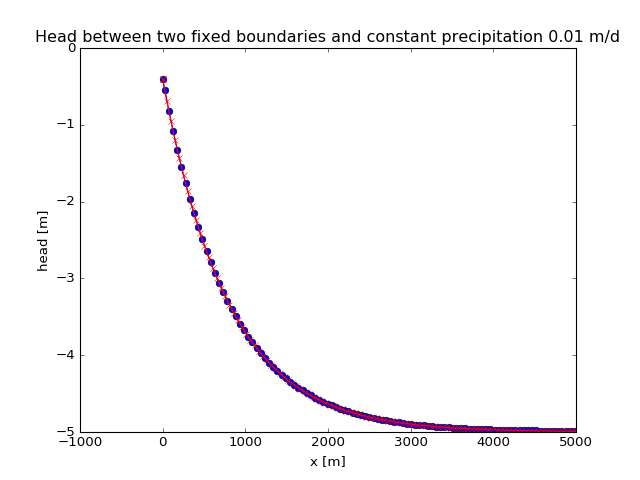

In [26]:
# %matplotlib notebook  # already done above
# import matplotlib.pyplot as plt # combines namespace of numpy and pyplot

plt.figure()
plt.xlabel('x [m]')
plt.ylabel('head [m]')
plt.title('Head between two fixed boundaries and constant precipitation {0} m/d'.format(N))

xm = 0.5 * (x[:-1] + x[1:])
plt.plot(xm, Phi[0][:,-1], 'bo-')

# now add the analytical solution
fi = hp + (hw - hp) * np.exp(-x/lam)
plt.plot(x, fi, 'xr-')


As can be seen, we get same result as before, but now with only two layers, of which the top one represents the semi confined layer in which center the head is prescribed.

## Cicular island with recharge

This examples uses a flat model (one layer) and places a fixed head outside the boundary of the island.

<IPython.core.display.Javascript object>


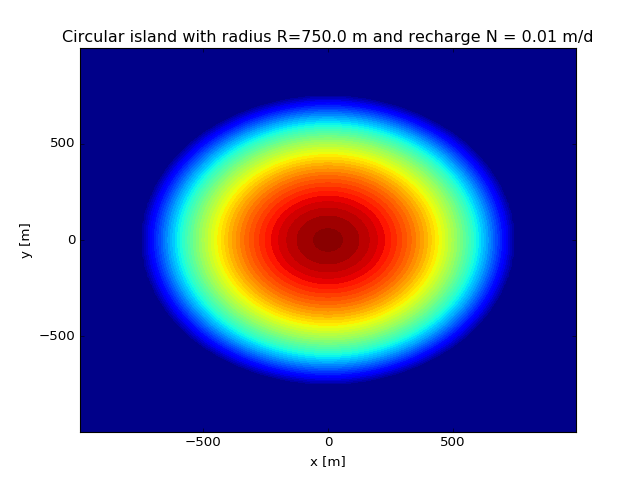

<IPython.core.display.Javascript object>


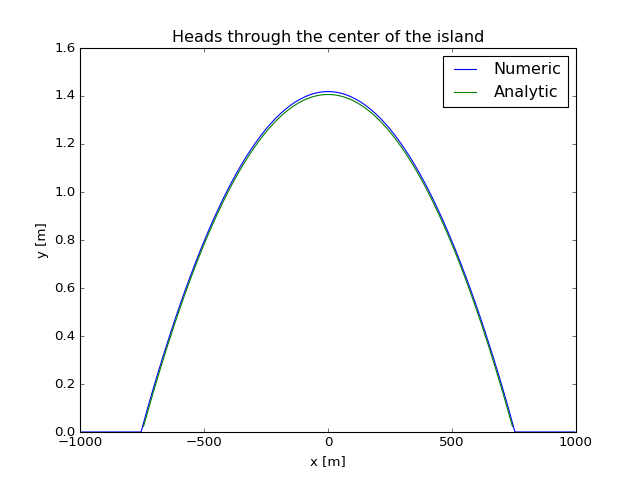

In [27]:
x = np.linspace(-1000., +1000., 200)
y = np.linspace(-1000., +1000., 200)
z = np.array([0., -100.])

xm = 0.5 * (x[:-1] + x[1:])
ym = 0.5 * (y[:-1] + y[1:])
zm = 0.5 * (z[:-1] + z[1:])

Nx = len(xm)
Ny = len(ym)
Nz = len(zm)

SHP = (Ny, Nx, Nz)

XM, YM, ZM = np.meshgrid(xm, ym, zm) # full 3D arrays of cell center coordinates

DX = np.abs(np.diff(x).reshape((1,Nx,1)) * np.ones(SHP))  # column width (3D aray)
DY = np.abs(np.diff(y).reshape((Ny,1,1)) * np.ones(SHP))  # row widths (3D array)

x0 = 0.; y0 = 0. # center of the island

RM = np.sqrt((XM - x0)**2 + (YM - y0)**2).reshape(SHP) # distance to center

R = 750.0 # [m] radius of the island

IBOUND = np.ones(SHP)
IBOUND[RM>R] = -1

k0 = 10 # [m/d]
k = k0 * np.ones(SHP) # uniform conductivity

kD = float(k0 * np.abs(np.diff(z)))

rch = 0.01 # [m/d] recharge rate
FQ = rch * DX * DY # [m3/d] cell inflows
IH = np.zeros(SHP) # [m] initial heads

Phi = fdm3(x, y, z, k, k, k, FQ, IH, IBOUND) # run model, return heads

# plot the heads a contours
plt.figure()
plt.xlabel('x [m]'); plt.ylabel('y [m]')
plt.title('Circular island with radius R={0} m and recharge N = {1} m/d'.format(R,N))
plt.contourf(xm,ym,Phi[:,:,0],50)

# plot the heads along the cross section and compare with analytical solution
plt.figure()
plt.xlabel('x [m]'); plt.ylabel('y [m]')
plt.title('Heads through the center of the island')
centerRow = int(np.floor(Ny/2))
plt.plot(xm, Phi[centerRow,:,0], label='Numeric')
Island = np.logical_and(xm>=-R, xm<=R)
plt.plot(xm[Island], N/(4 * kD) * (R**2 - xm[Island] ** 2), label='Analytic')
plt.legend()

Notice the difference between the analytic and numeric solution. This difference depends on the size of the number of cells that are used. The finer the model, the better the agreement. A small agreement remains because the boundary of the numeric model is not perfectly circular. We will a develop and use an axisymmetric model in the next chapter.

## Circular polder
This circular polder is also a circular island with fixed boundary at distance R from its center, but instead of a uniform recharge we have leakage through a semi-confining top layer that we will simulate using an extra layer.

Within the island we have a fixed head above the confining top layer. As an extra example we can choose to extend the polder to not be surrounded by open water with a fixed head but by other land where the head is fixed above the confing layer but at a different value.

Much of the set-up below is copied from the previous example.

<IPython.core.display.Javascript object>


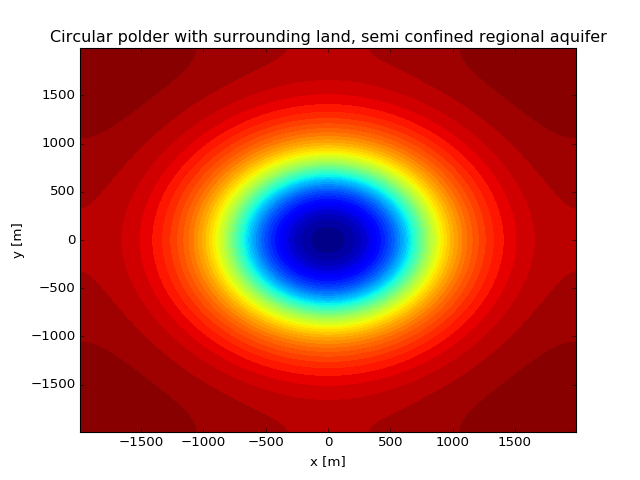

<IPython.core.display.Javascript object>


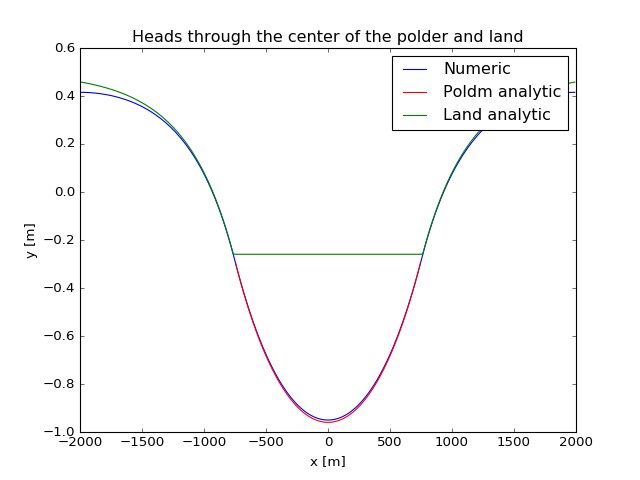

In [28]:
import scipy  # we need bessel functions

I0 = scipy.special.i0 # bessel function
I1 = scipy.special.i1 # same
K0 = scipy.special.k0 # same
K1 = scipy.special.k1 # same

z0=   0. # m, reference elevation, ground surface
d =  10. # m, thickness of confining layer
D = 100. # m, thickness of regional aquifer

R  = 750. # m, radius of island
x0 = 0.; y0 = 0. # center of the island

hp = -2.0  # m, maintained head r<=R
hl =  0.50 # m, maintained head r>R

c  = 250. # d, vertical hydraulic resistance of confining layer
k0 =  d/c # m/d vertical conductivity of confining layer
k1 = 10. # m/d, conductivity of regional layer
kD = k1 * D # m2/d transmissivity of regional aquifer
lam = np.sqrt(kD * c) # m, spreading or characteristic length of aquifer system

# The grid, coordinates and size
x = np.linspace(-2000., +2000., 200)
y = np.linspace(-2000., +2000., 200)
z = z0 - np.array([0, d, d+D])

xm = 0.5 * (x[:-1] + x[1:])
ym = 0.5 * (y[:-1] + y[1:])
zm = 0.5 * (z[:-1] + z[1:])

Nx = len(xm)
Ny = len(ym)
Nz = len(zm)

SHP = (Ny, Nx, Nz)

XM, YM, ZM = np.meshgrid(xm, ym, zm) # full 3D arrays of cell center coordinates

DX = np.abs(np.diff(x).reshape((1,Nx,1)) * np.ones(SHP))  # column width (3D aray)
DY = np.abs(np.diff(y).reshape((Ny,1,1)) * np.ones(SHP))  # row widths (3D array)

RM = np.sqrt((XM - x0)**2 + (YM - y0)**2).reshape(SHP) # distance to center
in_polder = RM[:,:,0]<=R
in_land   = np.logical_not(in_polder)

IBOUND = np.ones(SHP)
IBOUND[:,:,0] = -1  # maintain head everywhere in confining layer

k = np.ones(SHP) # uniform conductivity
k[:,:,0] = k0/2  # m/d, top layer
k[:,:,1] = k1  # m/d, bottom layer

rch = 0.01 # [m/d] recharge rate
FQ = np.zeros(SHP)# [m3/d] cell inflows

IH = np.zeros(SHP) # [m] initial heads
H  = np.ones((Ny, Nx)) # m, maintained head in top layer
H[in_land]  = hl # outside R
H[in_polder]= hp # inside R

IH[:,:,0] = H  # use in initial heads

Phi = fdm3(x, y, z, k, k, k, FQ, IH, IBOUND) # run model, return heads

# plot the heads a contours
plt.figure()
plt.xlabel('x [m]'); plt.ylabel('y [m]')
plt.title('Circular polder with surrounding land, semi confined regional aquifer')
plt.contourf(xm,ym,Phi[:,:,-1],50)

# plot the heads along the cross section and compare with analytical solution
plt.figure()
plt.xlabel('x [m]'); plt.ylabel('y [m]')
plt.title('Heads through the center of the polder and land')
centerRow = int(np.floor(Ny/2))

plt.plot(xm, Phi[centerRow,:,-1], label='Numeric')
Island = np.logical_and(xm>=-R, xm<=R)

# Analytical solution
RL = R/lam # shorthand

# head at x==R
xPold = xm[np.abs(xm)<=R]-x0 # inside polder
xLand = xm[np.abs(xm)> R]-y0 # outside polder

# head a x==R, analytical
phiR = (hp * I1(RL)/I0(RL) + hl* K1(RL)/K0(RL)) / (I1(RL)/I0(RL) + K1(RL)/K0(RL))

phiPold  = hp + (phiR - hp) * I0(np.abs(xPold)/lam) / I0(RL) # h in polder, r<=R
phiLand  = hl + (phiR - hl) * K0(np.abs(xLand)/lam) / K0(RL) # h outside polder, r> R

plt.plot(xPold, phiPold, 'r-', label='Poldm analytic')
plt.plot(xLand, phiLand, 'g-', label='Land analytic')

plt.legend()

The analytical solution matches the numerical one except near the edges of the model, where the model is closed and the analytical solution is not. The numerical solution, therefore, becomes horizontal near the boundary, indicating no flow across it. One also notices the distortion of the circular color field in the first figure due to the boundaries of the square shape of our model. Notice that the only boundary conditions in this model are prescribed heads in the top layer, which are different inside and outside the radius `R`.

One nicely see both analytical solutions, one for the land outside the polder (green) and one for the land inside teh polder (red).

There is a small difference between the numerical and analytical solution in the center. Again, this may be due to the fact that the circular polder can't be perfectly circular due to the rectangular cells of the model. But the larger the number of cells, the smaller the difference will be.

It is important to note that we used half the vertical conductivity of the top layer. This is because in the model, water flows vertically from the center of the toplayer, where the head is fixed to the bottom, that is, it passes only half the cell. To keep the resistance of this lower half of the cell equal to the given vertical hydraulic resisttance, we have to use $ k0 = (d/2) / c $ instead of $ k0 = d/c $

## More efficient coordinates
One sees that to set up a model, there area quite some lines that deal with the grid coordinates. This can be done a lot more efficient with a Grid class, the instances of which are invoked with the grid coordinates, after which a large number of variables can be requested from it, variables that are computed upon request.